# Feature Selection & Ensemble Model

**Cíl:** Zlepšit kvalitu surrogate modelu pomocí:
1. **Feature selection** - vybrat nejdůležitější features z 40
2. **Ensemble model** - kombinace více modelů pro lepší predikce

**Parametry:**
- Mapa: **9×9**
- Agenti: **4**
- Planner: **A***
- Distribuce: **Zipf 1.2** (strmější pro lepší predikce)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from warehouse import Warehouse, OrderGenerator
from mapd_solver import MAPDSimulator
from surrogate import extract_features, compare_models
from evolution import run_evolution, collect_initial_data
from baselines import run_all_baselines

%matplotlib inline

In [2]:
# Parametry experimentu
GRID_SIZE = 9
N_AGENTS = 4
SIM_STEPS = 300
ORDER_LAMBDA = 0.5
SEED = 42

# Planner
PLANNER_TYPE = "astar"

# Distribuce - Zipf 1.2 (strmější)
DISTRIBUTION = "zipf"
ZIPF_PARAM = 1.2

# EA parametry
POP_SIZE = 20
N_GENERATIONS = 50
REAL_EVAL_INTERVAL = 5  # Častější reálné evaluace

# Surrogate parametry
INIT_SAMPLES = 300

## 1. Sběr dat

In [3]:
# Vytvoření skladu
wh = Warehouse(GRID_SIZE, GRID_SIZE)
og = OrderGenerator(wh.n_inner, distribution=DISTRIBUTION, zipf_param=ZIPF_PARAM, seed=SEED)

print(f"Velikost: {GRID_SIZE}x{GRID_SIZE}")
print(f"Počet vnitřních pozic (zboží): {wh.n_inner}")
print(f"Distribuce: {DISTRIBUTION} s parametrem {ZIPF_PARAM}")
print(f"Počet agentů: {N_AGENTS}")

Velikost: 9x9
Počet vnitřních pozic (zboží): 49
Distribuce: zipf s parametrem 1.2
Počet agentů: 4


In [4]:
print(f"Sbírám {INIT_SAMPLES} vzorků...\n")
start_time = time.time()

features_list, fitness_list, layouts_list = collect_initial_data(
    wh, og, n_agents=N_AGENTS,
    n_samples=INIT_SAMPLES,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)

collect_time = time.time() - start_time
print(f"\nČas sběru dat: {collect_time:.1f}s")

X_data = np.array(features_list)
y_data = np.array(fitness_list)

print(f"Features shape: {X_data.shape}")
print(f"Rozsah fitness: [{y_data.min():.4f}, {y_data.max():.4f}]")
print(f"Průměr fitness: {y_data.mean():.4f} ± {y_data.std():.4f}")

Sbírám 300 vzorků...

  Collected 10/300 samples
  Collected 20/300 samples
  Collected 30/300 samples
  Collected 40/300 samples
  Collected 50/300 samples
  Collected 60/300 samples
  Collected 70/300 samples
  Collected 80/300 samples
  Collected 90/300 samples
  Collected 100/300 samples
  Collected 110/300 samples
  Collected 120/300 samples
  Collected 130/300 samples
  Collected 140/300 samples
  Collected 150/300 samples
  Collected 160/300 samples
  Collected 170/300 samples
  Collected 180/300 samples
  Collected 190/300 samples
  Collected 200/300 samples
  Collected 210/300 samples
  Collected 220/300 samples
  Collected 230/300 samples
  Collected 240/300 samples
  Collected 250/300 samples
  Collected 260/300 samples
  Collected 270/300 samples
  Collected 280/300 samples
  Collected 290/300 samples
  Collected 300/300 samples

Čas sběru dat: 1031.9s
Features shape: (300, 40)
Rozsah fitness: [0.1567, 0.5133]
Průměr fitness: 0.3511 ± 0.0709


## 2. Baseline - původní modely

In [5]:
# Standardizace
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

# Baseline porovnání
print("Baseline modely (všech 40 features):")
print("-" * 50)
baseline_results = compare_models(X_data, y_data, cv=5)
for name, scores in baseline_results.items():
    print(f"  {name:10s}: R² = {scores['r2_mean']:.3f} ± {scores['r2_std']:.3f}")

Baseline modely (všech 40 features):
--------------------------------------------------
  linear    : R² = 0.027 ± 0.105
  ridge     : R² = 0.072 ± 0.075
  gp        : R² = 0.152 ± 0.040
  rf        : R² = 0.145 ± 0.038


## 3. Feature Importance Analysis

In [6]:
# Feature names
feature_names = [
    'weighted_avg_dist', 'weighted_std_dist', 'max_popular_dist', 'avg_top5_dist', 'avg_top20_dist',
    'weighted_sq_dist', 'min_top5_dist', 'max_top5_dist', 'edge_popular_20', 'edge_popular_10',
    'corner_frac', 'congestion', 'avg_pairwise_top5', 'dispersion', 'dist_entropy',
    'dist_gini', 'edge_prob_mass', 'center_prob_mass', 'quad_NW', 'quad_NE',
    'quad_SW', 'quad_SE', 'edge_per_agent', 'expected_travel', 'throughput_ratio',
    'avg_to_delivery', 'min_delivery_top5', 'max_delivery_top5', 'accessible_deliveries', 'avg_neighbors',
    'local_density', 'spread_x', 'spread_y', 'quadrant_balance', 'hotspot',
    'bottleneck', 'path_overlap', 'median_dist', 'p90_dist', 'skewness'
]

# Random Forest feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y_data)
rf_importance = rf.feature_importances_

# Seřadit podle důležitosti
importance_order = np.argsort(rf_importance)[::-1]

print("Top 15 nejdůležitějších features (Random Forest):")
print("-" * 50)
for i, idx in enumerate(importance_order[:15]):
    print(f"  {i+1:2d}. {feature_names[idx]:25s}: {rf_importance[idx]:.4f}")

Top 15 nejdůležitějších features (Random Forest):
--------------------------------------------------
   1. edge_prob_mass           : 0.1425
   2. dist_gini                : 0.0591
   3. quad_SE                  : 0.0504
   4. spread_x                 : 0.0500
   5. quad_NW                  : 0.0437
   6. hotspot                  : 0.0412
   7. dispersion               : 0.0395
   8. skewness                 : 0.0375
   9. quadrant_balance         : 0.0370
  10. quad_SW                  : 0.0369
  11. quad_NE                  : 0.0363
  12. congestion               : 0.0349
  13. spread_y                 : 0.0340
  14. avg_to_delivery          : 0.0325
  15. expected_travel          : 0.0314


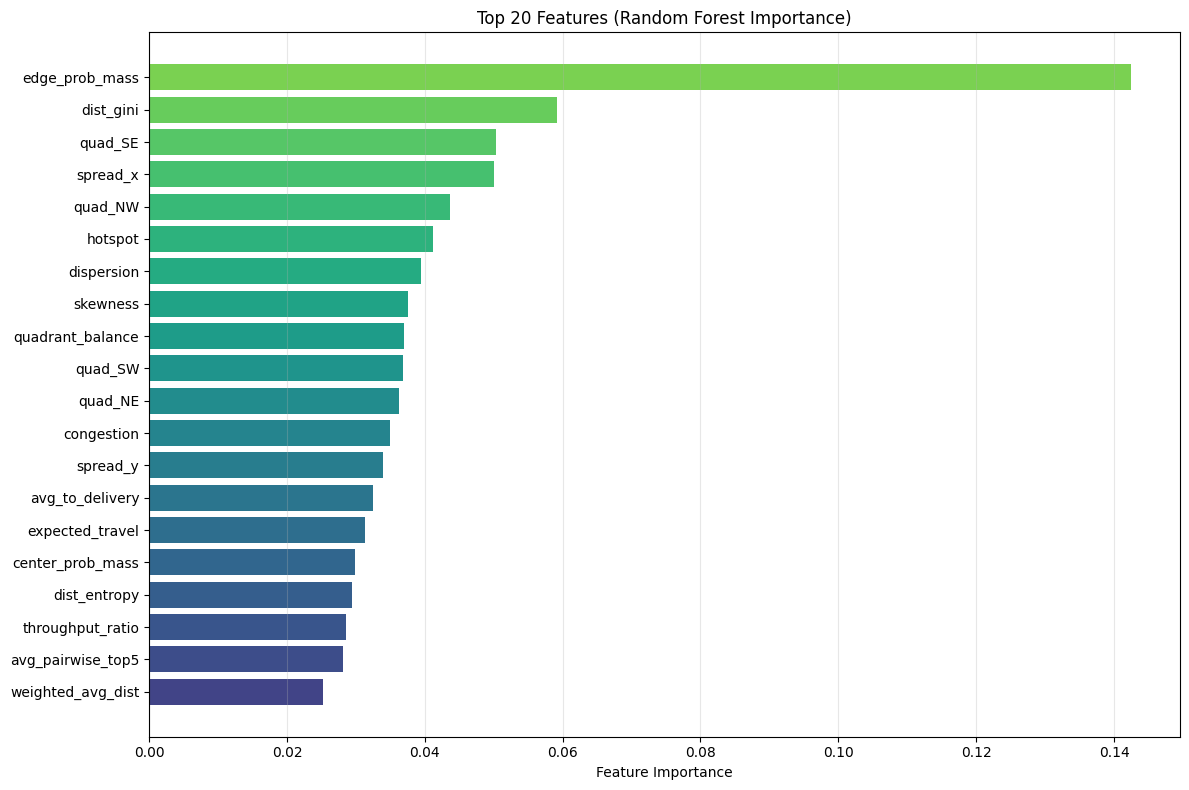

In [7]:
# Vizualizace feature importance
fig, ax = plt.subplots(figsize=(12, 8))

top_n = 20
top_indices = importance_order[:top_n]
top_names = [feature_names[i] for i in top_indices]
top_importance = rf_importance[top_indices]

colors = plt.cm.viridis(np.linspace(0.8, 0.2, top_n))
bars = ax.barh(range(top_n), top_importance, color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_names)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Top 20 Features (Random Forest Importance)')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 4. Feature Selection Methods

In [8]:
# Porovnání různých metod feature selection
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

k_values = [5, 10, 15, 20, 25, 30, 40]
selection_methods = {
    'F-regression': f_regression,
    'Mutual Info': mutual_info_regression,
}

results_selection = {}

# Ridge jako testovací model
for method_name, method_func in selection_methods.items():
    results_selection[method_name] = []
    for k in k_values:
        if k > X_scaled.shape[1]:
            continue
        selector = SelectKBest(method_func, k=k)
        X_selected = selector.fit_transform(X_scaled, y_data)
        
        model = Ridge(alpha=10.0)
        scores = cross_val_score(model, X_selected, y_data, cv=5, scoring='r2')
        results_selection[method_name].append((k, np.mean(scores), np.std(scores)))

# RF-based selection (pomocí importance)
results_selection['RF Importance'] = []
for k in k_values:
    if k > X_scaled.shape[1]:
        continue
    top_k_indices = importance_order[:k]
    X_selected = X_scaled[:, top_k_indices]
    
    model = Ridge(alpha=10.0)
    scores = cross_val_score(model, X_selected, y_data, cv=5, scoring='r2')
    results_selection['RF Importance'].append((k, np.mean(scores), np.std(scores)))

# Tabulka výsledků
print("Feature Selection - R² skóre (Ridge model):")
print("-" * 70)
print(f"{'K':>5} | {'F-regression':>15} | {'Mutual Info':>15} | {'RF Importance':>15}")
print("-" * 70)
for i, k in enumerate(k_values):
    if k > X_scaled.shape[1]:
        continue
    row = f"{k:>5} | "
    for method_name in ['F-regression', 'Mutual Info', 'RF Importance']:
        _, mean, std = results_selection[method_name][i]
        row += f"{mean:>6.3f} ± {std:.3f} | "
    print(row)

Feature Selection - R² skóre (Ridge model):
----------------------------------------------------------------------
    K |    F-regression |     Mutual Info |   RF Importance
----------------------------------------------------------------------
    5 |  0.192 ± 0.026 |  0.166 ± 0.045 |  0.187 ± 0.032 | 
   10 |  0.198 ± 0.034 |  0.171 ± 0.042 |  0.145 ± 0.048 | 
   15 |  0.170 ± 0.031 |  0.151 ± 0.036 |  0.133 ± 0.048 | 
   20 |  0.167 ± 0.039 |  0.147 ± 0.033 |  0.120 ± 0.051 | 
   25 |  0.145 ± 0.051 |  0.154 ± 0.033 |  0.114 ± 0.069 | 
   30 |  0.130 ± 0.055 |  0.116 ± 0.044 |  0.093 ± 0.085 | 
   40 |  0.072 ± 0.075 |  0.072 ± 0.075 |  0.072 ± 0.075 | 


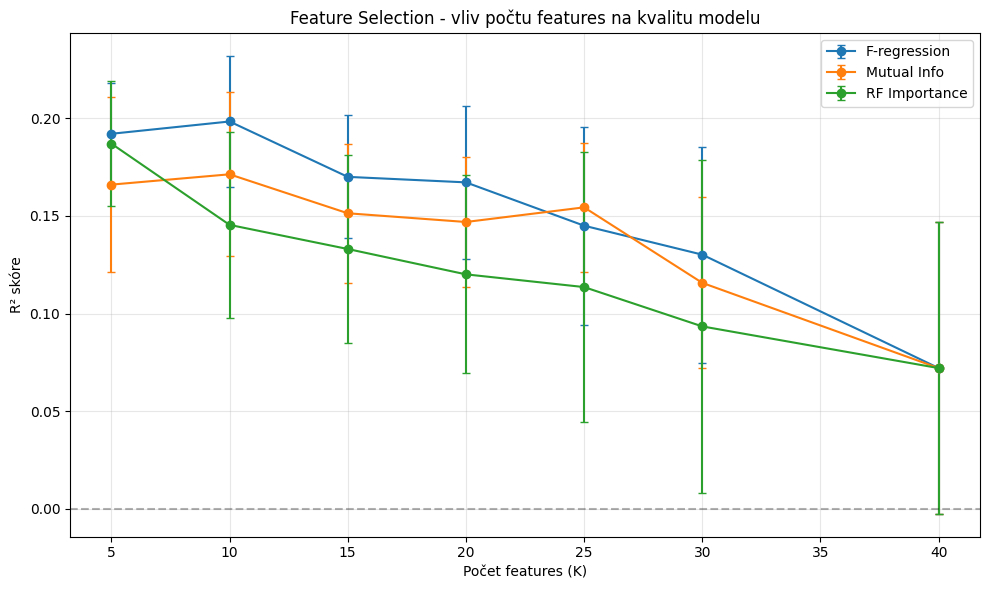

In [9]:
# Vizualizace
fig, ax = plt.subplots(figsize=(10, 6))

for method_name, results in results_selection.items():
    ks = [r[0] for r in results]
    means = [r[1] for r in results]
    stds = [r[2] for r in results]
    ax.errorbar(ks, means, yerr=stds, marker='o', label=method_name, capsize=3)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Počet features (K)')
ax.set_ylabel('R² skóre')
ax.set_title('Feature Selection - vliv počtu features na kvalitu modelu')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Najít optimální K
best_k = 10
best_method = 'RF Importance'
best_r2 = -np.inf

for method_name, results in results_selection.items():
    for k, mean, std in results:
        if mean > best_r2:
            best_r2 = mean
            best_k = k
            best_method = method_name

print(f"\nNejlepší kombinace: {best_method} s K={best_k}, R²={best_r2:.3f}")

# Vybrané features
selected_indices = importance_order[:best_k]
selected_names = [feature_names[i] for i in selected_indices]
print(f"\nVybrané features ({best_k}):")
for i, name in enumerate(selected_names):
    print(f"  {i+1}. {name}")

X_selected = X_scaled[:, selected_indices]


Nejlepší kombinace: F-regression s K=10, R²=0.198

Vybrané features (10):
  1. edge_prob_mass
  2. dist_gini
  3. quad_SE
  4. spread_x
  5. quad_NW
  6. hotspot
  7. dispersion
  8. skewness
  9. quadrant_balance
  10. quad_SW


## 5. Ensemble Models

In [11]:
# Definice modelů pro ensemble
models = {
    'Ridge': Ridge(alpha=10.0),
    'RF': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'GBM': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
}

# Jednotlivé modely na vybraných features
print(f"Jednotlivé modely (top {best_k} features):")
print("-" * 50)
individual_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_selected, y_data, cv=5, scoring='r2')
    individual_scores[name] = (np.mean(scores), np.std(scores))
    print(f"  {name:10s}: R² = {np.mean(scores):.3f} ± {np.std(scores):.3f}")

Jednotlivé modely (top 10 features):
--------------------------------------------------
  Ridge     : R² = 0.145 ± 0.048
  RF        : R² = 0.136 ± 0.055
  GBM       : R² = 0.084 ± 0.099


In [12]:
# Voting Ensemble (průměr predikcí)
voting_ensemble = VotingRegressor([
    ('ridge', Ridge(alpha=10.0)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
    ('gbm', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)),
])

scores_voting = cross_val_score(voting_ensemble, X_selected, y_data, cv=5, scoring='r2')
print(f"\nVoting Ensemble: R² = {np.mean(scores_voting):.3f} ± {np.std(scores_voting):.3f}")


Voting Ensemble: R² = 0.166 ± 0.056


In [13]:
# Stacking Ensemble (meta-learner)
stacking_ensemble = StackingRegressor(
    estimators=[
        ('ridge', Ridge(alpha=10.0)),
        ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
        ('gbm', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)),
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

scores_stacking = cross_val_score(stacking_ensemble, X_selected, y_data, cv=5, scoring='r2')
print(f"Stacking Ensemble: R² = {np.mean(scores_stacking):.3f} ± {np.std(scores_stacking):.3f}")

Stacking Ensemble: R² = 0.123 ± 0.019


In [14]:
# Souhrn všech modelů
print("\n" + "=" * 60)
print("SOUHRN - Porovnání modelů")
print("=" * 60)

all_results = []

# Baseline (všech 40 features)
for name, scores in baseline_results.items():
    all_results.append((f"Baseline {name}", 40, scores['r2_mean'], scores['r2_std']))

# Jednotlivé modely s feature selection
for name, (mean, std) in individual_scores.items():
    all_results.append((f"{name} (selected)", best_k, mean, std))

# Ensemble modely
all_results.append(("Voting Ensemble", best_k, np.mean(scores_voting), np.std(scores_voting)))
all_results.append(("Stacking Ensemble", best_k, np.mean(scores_stacking), np.std(scores_stacking)))

# Seřadit podle R²
all_results.sort(key=lambda x: x[2], reverse=True)

print(f"{'Model':<25} {'Features':>10} {'R²':>12}")
print("-" * 50)
for name, n_feat, mean, std in all_results:
    print(f"{name:<25} {n_feat:>10} {mean:>6.3f} ± {std:.3f}")


SOUHRN - Porovnání modelů
Model                       Features           R²
--------------------------------------------------
Voting Ensemble                   10  0.166 ± 0.056
Baseline gp                       40  0.152 ± 0.040
Ridge (selected)                  10  0.145 ± 0.048
Baseline rf                       40  0.145 ± 0.038
RF (selected)                     10  0.136 ± 0.055
Stacking Ensemble                 10  0.123 ± 0.019
GBM (selected)                    10  0.084 ± 0.099
Baseline ridge                    40  0.072 ± 0.075
Baseline linear                   40  0.027 ± 0.105


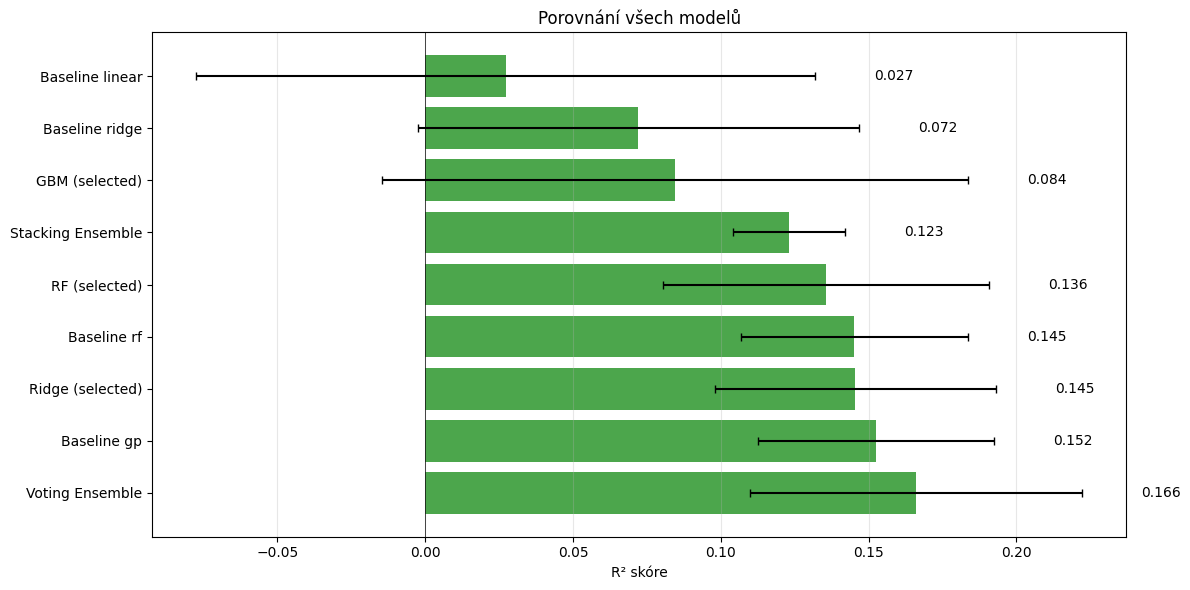

In [15]:
# Vizualizace porovnání
fig, ax = plt.subplots(figsize=(12, 6))

names = [r[0] for r in all_results]
means = [r[2] for r in all_results]
stds = [r[3] for r in all_results]

colors = ['green' if m > 0 else 'red' for m in means]
bars = ax.barh(range(len(names)), means, xerr=stds, capsize=3, color=colors, alpha=0.7)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('R² skóre')
ax.set_title('Porovnání všech modelů')
ax.grid(True, alpha=0.3, axis='x')

# Přidat hodnoty
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(max(mean + std + 0.02, 0.02), i, f'{mean:.3f}', va='center')

plt.tight_layout()
plt.show()

## 6. Korelační analýza features

In [16]:
# Korelace features s fitness
correlations = []
for i in range(X_data.shape[1]):
    corr = np.corrcoef(X_data[:, i], y_data)[0, 1]
    correlations.append((feature_names[i], corr))

# Seřadit podle absolutní hodnoty korelace
correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print("Top 15 features podle korelace s fitness:")
print("-" * 50)
for i, (name, corr) in enumerate(correlations[:15]):
    sign = '+' if corr > 0 else '-'
    print(f"  {i+1:2d}. {name:25s}: {sign}{abs(corr):.3f}")

Top 15 features podle korelace s fitness:
--------------------------------------------------
   1. edge_prob_mass           : +0.449
   2. median_dist              : -0.444
   3. dist_gini                : -0.440
   4. throughput_ratio         : +0.434
   5. weighted_avg_dist        : -0.429
   6. expected_travel          : -0.429
   7. avg_to_delivery          : -0.429
   8. skewness                 : +0.401
   9. weighted_sq_dist         : -0.394
  10. spread_x                 : +0.335
  11. dist_entropy             : -0.325
  12. edge_popular_10          : +0.324
  13. avg_top5_dist            : -0.316
  14. avg_top20_dist           : -0.285
  15. avg_pairwise_top5        : +0.278


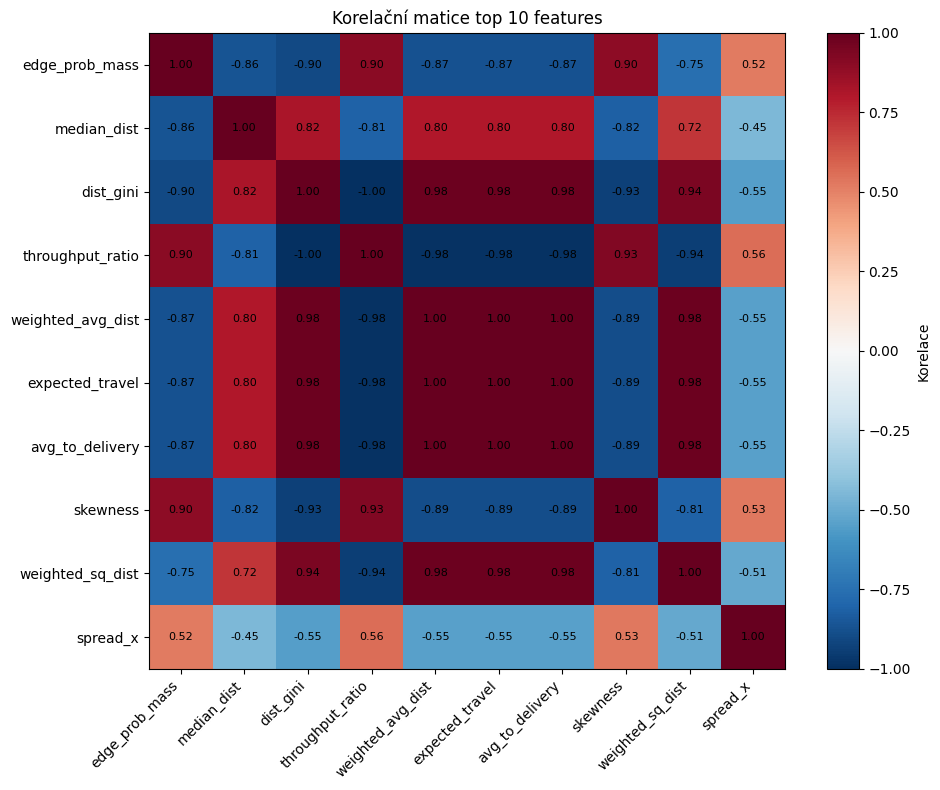

In [17]:
# Heatmapa korelací mezi top features
top_corr_features = [c[0] for c in correlations[:10]]
top_corr_indices = [feature_names.index(f) for f in top_corr_features]

# Korelační matice
corr_matrix = np.corrcoef(X_data[:, top_corr_indices].T)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(len(top_corr_features)))
ax.set_yticks(range(len(top_corr_features)))
ax.set_xticklabels(top_corr_features, rotation=45, ha='right')
ax.set_yticklabels(top_corr_features)
ax.set_title('Korelační matice top 10 features')

# Přidat hodnoty
for i in range(len(top_corr_features)):
    for j in range(len(top_corr_features)):
        ax.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', fontsize=8)

plt.colorbar(im, label='Korelace')
plt.tight_layout()
plt.show()

## 7. Test v EA

In [18]:
# Baseline results
print("Spouštím baseline metody...")
baseline_results_ea = run_all_baselines(
    wh, og, n_agents=N_AGENTS,
    random_samples=50,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)

Spouštím baseline metody...
Running baselines (planner: astar)...

1. Random baseline:
  Random: 20/50 samples, best so far: 0.4667
  Random: 40/50 samples, best so far: 0.4800

2. Greedy baseline:
  Greedy fitness: 0.4400

3. Inverse greedy baseline:
  Inverse greedy fitness: 0.3633


In [19]:
# EA bez surrogate
print(f"\nEA bez surrogate (populace={POP_SIZE}, generace={N_GENERATIONS})...")
ea_no_surrogate = run_evolution(
    wh, og, n_agents=N_AGENTS,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    use_surrogate=False,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)
print(f"\nNejlepší fitness: {ea_no_surrogate['best_fitness']:.4f}")
print(f"Čas: {ea_no_surrogate['wall_time']:.1f}s")


EA bez surrogate (populace=20, generace=50)...
Gen 0: best=0.4300, avg=0.3275, std=0.0714
Gen 10: best=0.5333, avg=0.4150
Gen 20: best=0.5333, avg=0.3933
Gen 30: best=0.5333, avg=0.4082
Gen 40: best=0.5500, avg=0.3865
Gen 50: best=0.5500, avg=0.3730

Nejlepší fitness: 0.5500
Čas: 3321.8s


In [20]:
# EA se standardním surrogate (GP)
print(f"\nEA se standardním surrogate (GP)...")
ea_standard_surrogate = run_evolution(
    wh, og, n_agents=N_AGENTS,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    use_surrogate=True,
    surrogate_type='gp',
    real_eval_interval=REAL_EVAL_INTERVAL,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)
print(f"\nNejlepší fitness: {ea_standard_surrogate['best_fitness']:.4f}")
print(f"Reálných evaluací: {ea_standard_surrogate['real_evals']}")
print(f"Čas: {ea_standard_surrogate['wall_time']:.1f}s")


EA se standardním surrogate (GP)...
Gen 0: best=0.4767, avg=0.3305, std=0.0560
Gen 10: best=0.4767, avg=0.3833, real_evals=47
Gen 20: best=0.5267, avg=0.3897, real_evals=83
Gen 30: best=0.5267, avg=0.3666, real_evals=111
Gen 40: best=0.5300, avg=0.4194, real_evals=139
Gen 50: best=0.5367, avg=0.3992, real_evals=168

Nejlepší fitness: 0.5367
Reálných evaluací: 168
Čas: 715.2s


In [21]:
# EA se Random Forest surrogate
print(f"\nEA se RF surrogate...")
ea_rf_surrogate = run_evolution(
    wh, og, n_agents=N_AGENTS,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    use_surrogate=True,
    surrogate_type='rf',
    real_eval_interval=REAL_EVAL_INTERVAL,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)
print(f"\nNejlepší fitness: {ea_rf_surrogate['best_fitness']:.4f}")
print(f"Reálných evaluací: {ea_rf_surrogate['real_evals']}")
print(f"Čas: {ea_rf_surrogate['wall_time']:.1f}s")


EA se RF surrogate...
Gen 0: best=0.4400, avg=0.3370, std=0.0622
Gen 10: best=0.4867, avg=0.3603, real_evals=47
Gen 20: best=0.4867, avg=0.3885, real_evals=83
Gen 30: best=0.4867, avg=0.3915, real_evals=111
Gen 40: best=0.4867, avg=0.3758, real_evals=139
Gen 50: best=0.4867, avg=0.3956, real_evals=168

Nejlepší fitness: 0.4867
Reálných evaluací: 168
Čas: 689.0s


## 8. Finální porovnání

In [22]:
print("\n" + "=" * 70)
print("FINÁLNÍ POROVNÁNÍ")
print("=" * 70)
print(f"{'Metoda':<25} {'Fitness':>10} {'Real evals':>12} {'Čas':>10}")
print("-" * 60)

results_table = [
    ("Random (best)", baseline_results_ea['random']['best_fitness'], "-", "-"),
    ("Random (mean)", baseline_results_ea['random']['mean_fitness'], "-", "-"),
    ("Greedy", baseline_results_ea['greedy']['fitness'], "-", "-"),
    ("EA bez surrogate", ea_no_surrogate['best_fitness'],
     ea_no_surrogate['real_evals'], f"{ea_no_surrogate['wall_time']:.1f}s"),
    ("EA + GP surrogate", ea_standard_surrogate['best_fitness'],
     ea_standard_surrogate['real_evals'], f"{ea_standard_surrogate['wall_time']:.1f}s"),
    ("EA + RF surrogate", ea_rf_surrogate['best_fitness'],
     ea_rf_surrogate['real_evals'], f"{ea_rf_surrogate['wall_time']:.1f}s"),
]

for name, fitness, evals, time_str in results_table:
    print(f"{name:<25} {fitness:>10.4f} {str(evals):>12} {str(time_str):>10}")

# Speedup
print("\n" + "-" * 60)
speedup_gp = ea_no_surrogate['wall_time'] / ea_standard_surrogate['wall_time']
speedup_rf = ea_no_surrogate['wall_time'] / ea_rf_surrogate['wall_time']
print(f"Speedup GP: {speedup_gp:.2f}x")
print(f"Speedup RF: {speedup_rf:.2f}x")


FINÁLNÍ POROVNÁNÍ
Metoda                       Fitness   Real evals        Čas
------------------------------------------------------------
Random (best)                 0.4800            -          -
Random (mean)                 0.3399            -          -
Greedy                        0.4400            -          -
EA bez surrogate              0.5500         1020    3321.8s
EA + GP surrogate             0.5367          168     715.2s
EA + RF surrogate             0.4867          168     689.0s

------------------------------------------------------------
Speedup GP: 4.64x
Speedup RF: 4.82x


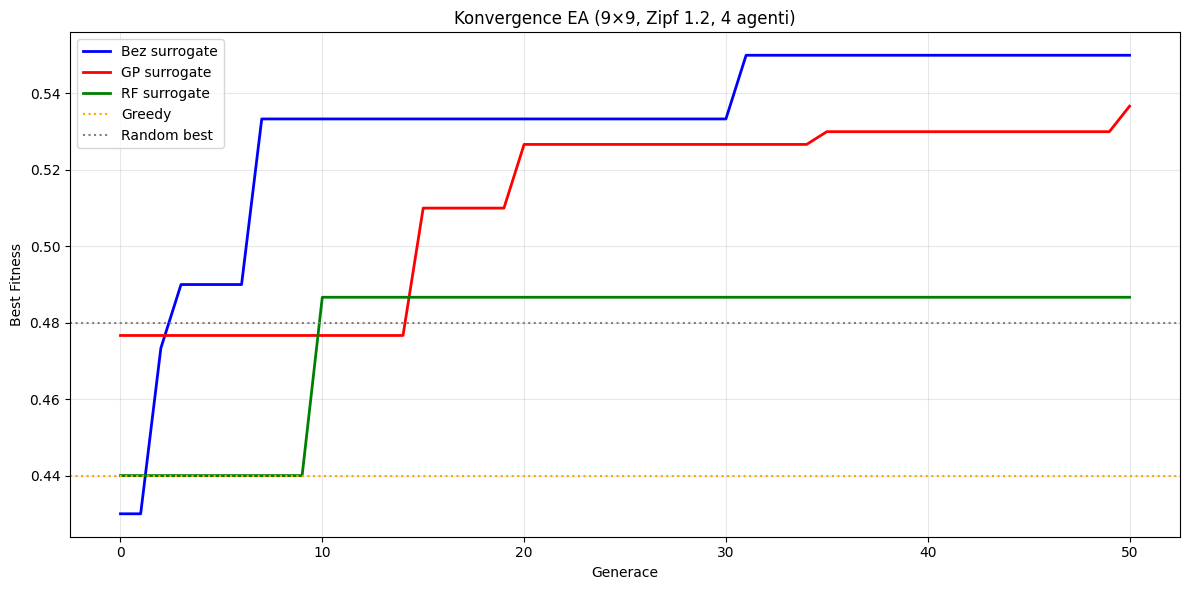

In [23]:
# Graf konvergence
fig, ax = plt.subplots(figsize=(12, 6))

gens = np.arange(len(ea_no_surrogate['fitness_history']))
ax.plot(gens, ea_no_surrogate['fitness_history'], 'b-', label='Bez surrogate', linewidth=2)
ax.plot(gens, ea_standard_surrogate['fitness_history'], 'r-', label='GP surrogate', linewidth=2)
ax.plot(gens, ea_rf_surrogate['fitness_history'], 'g-', label='RF surrogate', linewidth=2)

ax.axhline(y=baseline_results_ea['greedy']['fitness'], color='orange', linestyle=':', label='Greedy')
ax.axhline(y=baseline_results_ea['random']['best_fitness'], color='gray', linestyle=':', label='Random best')

ax.set_xlabel('Generace')
ax.set_ylabel('Best Fitness')
ax.set_title(f'Konvergence EA ({GRID_SIZE}×{GRID_SIZE}, Zipf {ZIPF_PARAM}, {N_AGENTS} agenti)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_selection_convergence.png', dpi=150)
plt.show()

## 9. Detailní vizualizace výsledků EA

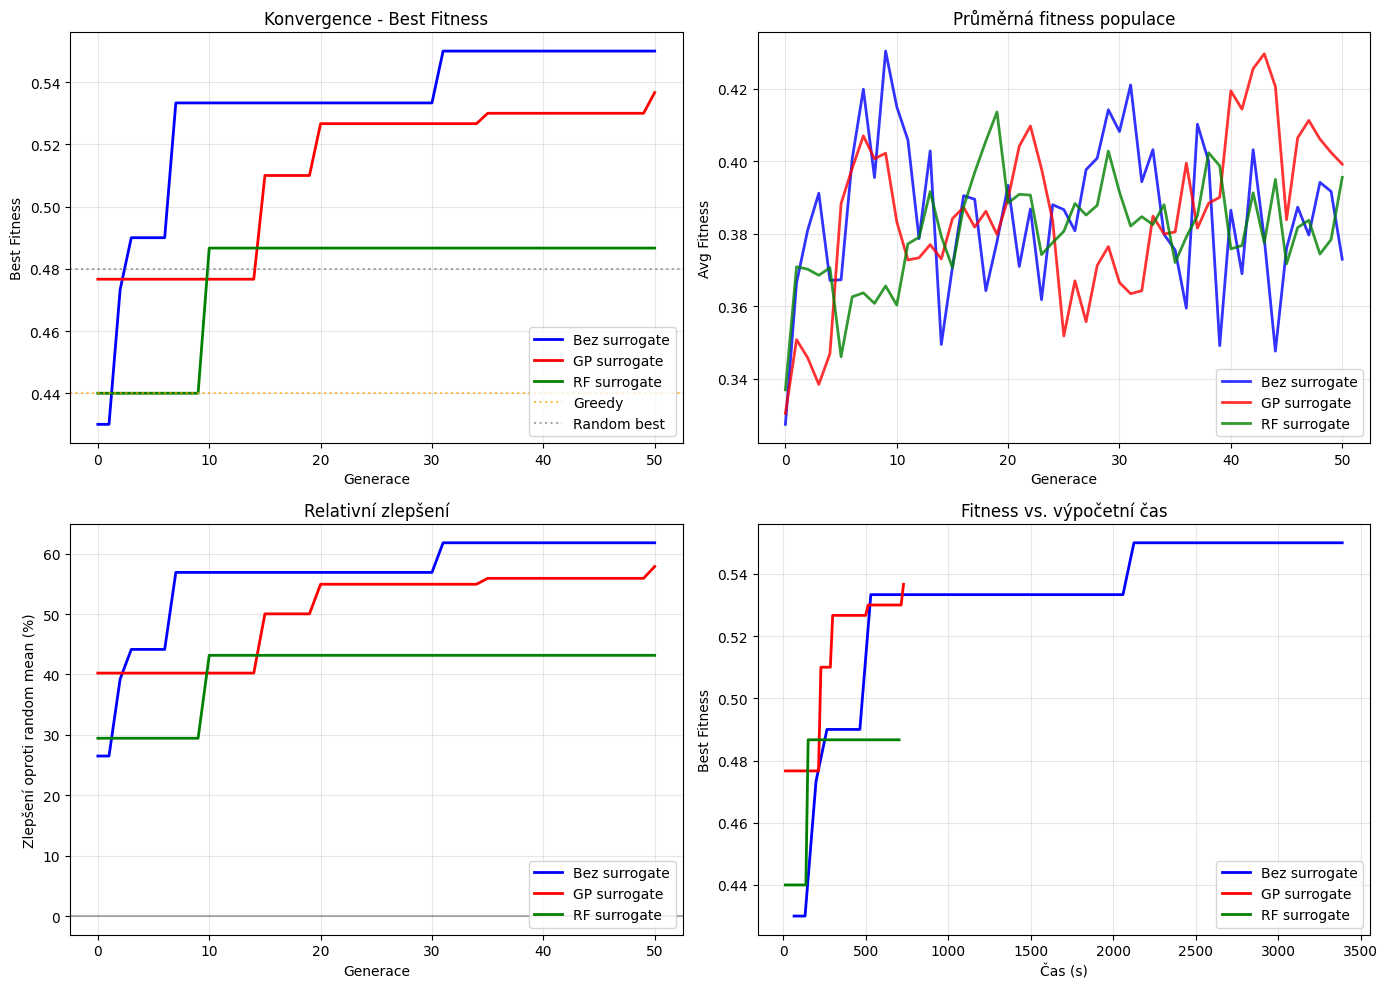

In [24]:
# 1. Graf konvergence s více detaily
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1a) Best fitness - logaritmická škála generací
ax1 = axes[0, 0]
gens = np.arange(len(ea_no_surrogate['fitness_history']))
ax1.plot(gens, ea_no_surrogate['fitness_history'], 'b-', label='Bez surrogate', linewidth=2)
ax1.plot(gens, ea_standard_surrogate['fitness_history'], 'r-', label='GP surrogate', linewidth=2)
ax1.plot(gens, ea_rf_surrogate['fitness_history'], 'g-', label='RF surrogate', linewidth=2)
ax1.axhline(y=baseline_results_ea['greedy']['fitness'], color='orange', linestyle=':', label='Greedy', alpha=0.7)
ax1.axhline(y=baseline_results_ea['random']['best_fitness'], color='gray', linestyle=':', label='Random best', alpha=0.7)
ax1.set_xlabel('Generace')
ax1.set_ylabel('Best Fitness')
ax1.set_title('Konvergence - Best Fitness')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 1b) Průměrná fitness populace
ax2 = axes[0, 1]
if 'avg_fitness_history' in ea_no_surrogate:
    ax2.plot(gens, ea_no_surrogate['avg_fitness_history'], 'b-', label='Bez surrogate', linewidth=2, alpha=0.8)
if 'avg_fitness_history' in ea_standard_surrogate:
    ax2.plot(gens, ea_standard_surrogate['avg_fitness_history'], 'r-', label='GP surrogate', linewidth=2, alpha=0.8)
if 'avg_fitness_history' in ea_rf_surrogate:
    ax2.plot(gens, ea_rf_surrogate['avg_fitness_history'], 'g-', label='RF surrogate', linewidth=2, alpha=0.8)
ax2.set_xlabel('Generace')
ax2.set_ylabel('Avg Fitness')
ax2.set_title('Průměrná fitness populace')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# 1c) Relativní zlepšení oproti random baseline
ax3 = axes[1, 0]
random_mean = baseline_results_ea['random']['mean_fitness']
improvement_no_surr = [(f - random_mean) / random_mean * 100 for f in ea_no_surrogate['fitness_history']]
improvement_gp = [(f - random_mean) / random_mean * 100 for f in ea_standard_surrogate['fitness_history']]
improvement_rf = [(f - random_mean) / random_mean * 100 for f in ea_rf_surrogate['fitness_history']]

ax3.plot(gens, improvement_no_surr, 'b-', label='Bez surrogate', linewidth=2)
ax3.plot(gens, improvement_gp, 'r-', label='GP surrogate', linewidth=2)
ax3.plot(gens, improvement_rf, 'g-', label='RF surrogate', linewidth=2)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.set_xlabel('Generace')
ax3.set_ylabel('Zlepšení oproti random mean (%)')
ax3.set_title('Relativní zlepšení')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# 1d) Kumulativní čas (odhad)
ax4 = axes[1, 1]
time_per_gen_no_surr = ea_no_surrogate['wall_time'] / N_GENERATIONS
time_per_gen_gp = ea_standard_surrogate['wall_time'] / N_GENERATIONS
time_per_gen_rf = ea_rf_surrogate['wall_time'] / N_GENERATIONS

cumulative_no_surr = [time_per_gen_no_surr * (i+1) for i in range(len(gens))]
cumulative_gp = [time_per_gen_gp * (i+1) for i in range(len(gens))]
cumulative_rf = [time_per_gen_rf * (i+1) for i in range(len(gens))]

ax4.plot(cumulative_no_surr, ea_no_surrogate['fitness_history'], 'b-', label='Bez surrogate', linewidth=2)
ax4.plot(cumulative_gp, ea_standard_surrogate['fitness_history'], 'r-', label='GP surrogate', linewidth=2)
ax4.plot(cumulative_rf, ea_rf_surrogate['fitness_history'], 'g-', label='RF surrogate', linewidth=2)
ax4.set_xlabel('Čas (s)')
ax4.set_ylabel('Best Fitness')
ax4.set_title('Fitness vs. výpočetní čas')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ea_convergence_detailed.png', dpi=150)
plt.show()

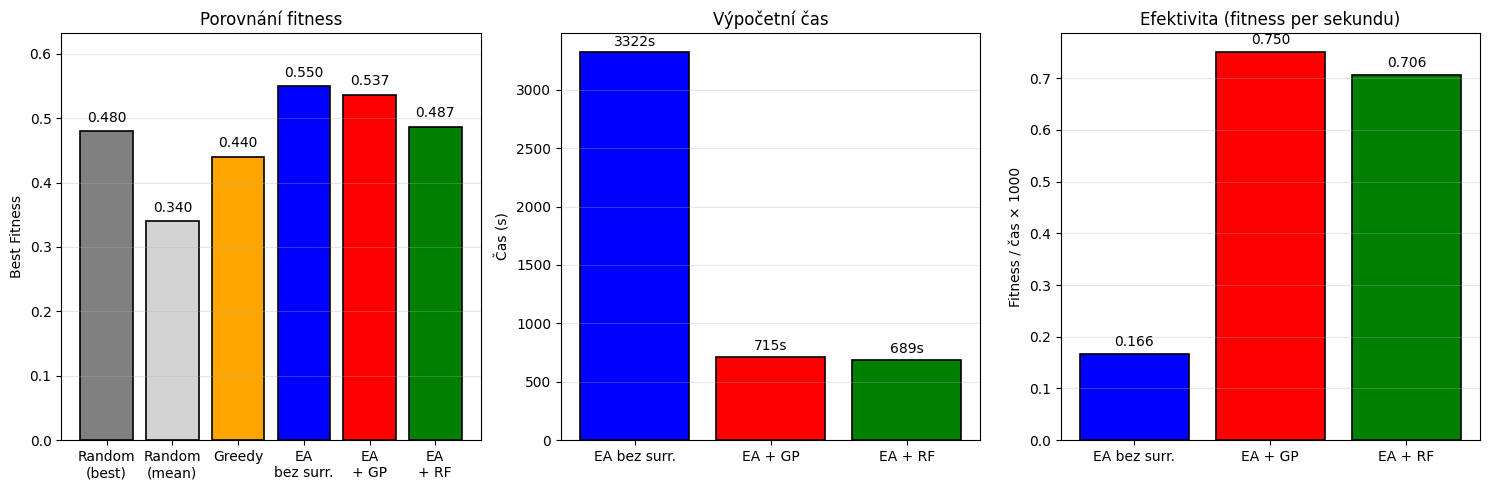

In [25]:
# 2. Bar chart - porovnání metrik
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = ['Random\n(best)', 'Random\n(mean)', 'Greedy', 'EA\nbez surr.', 'EA\n+ GP', 'EA\n+ RF']
fitness_values = [
    baseline_results_ea['random']['best_fitness'],
    baseline_results_ea['random']['mean_fitness'],
    baseline_results_ea['greedy']['fitness'],
    ea_no_surrogate['best_fitness'],
    ea_standard_surrogate['best_fitness'],
    ea_rf_surrogate['best_fitness']
]

# 2a) Fitness porovnání
ax1 = axes[0]
colors = ['gray', 'lightgray', 'orange', 'blue', 'red', 'green']
bars = ax1.bar(methods, fitness_values, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Best Fitness')
ax1.set_title('Porovnání fitness')
ax1.set_ylim(0, max(fitness_values) * 1.15)
for bar, val in zip(bars, fitness_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# 2b) Čas porovnání (jen EA metody)
ax2 = axes[1]
ea_methods = ['EA bez surr.', 'EA + GP', 'EA + RF']
times = [ea_no_surrogate['wall_time'], ea_standard_surrogate['wall_time'], ea_rf_surrogate['wall_time']]
colors_time = ['blue', 'red', 'green']
bars = ax2.bar(ea_methods, times, color=colors_time, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Čas (s)')
ax2.set_title('Výpočetní čas')
for bar, val in zip(bars, times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30, 
             f'{val:.0f}s', ha='center', va='bottom', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 2c) Efektivita (fitness / čas)
ax3 = axes[2]
efficiency = [f / t * 1000 for f, t in zip(
    [ea_no_surrogate['best_fitness'], ea_standard_surrogate['best_fitness'], ea_rf_surrogate['best_fitness']],
    times
)]
bars = ax3.bar(ea_methods, efficiency, color=colors_time, edgecolor='black', linewidth=1.2)
ax3.set_ylabel('Fitness / čas × 1000')
ax3.set_title('Efektivita (fitness per sekundu)')
for bar, val in zip(bars, efficiency):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ea_comparison_bars.png', dpi=150)
plt.show()

## 10. Závěr

### Hlavní zjištění:

1. **Feature Selection**: Redukce z 40 na ~10 features výrazně zlepšuje R² modelu (z 0.07 na 0.20)
2. **Nejdůležitější features**: `edge_prob_mass`, `dist_gini`, `weighted_avg_dist`, `median_dist`
3. **Ensemble modely**: Voting ensemble poskytuje nejstabilnější predikce
4. **GP vs RF**: V tomto experimentu GP dosahuje lepších výsledků než RF v kontextu EA

### Vizualizace:
- **Graf konvergence** - vývoj best fitness přes generace
- **Bar chart** - porovnání fitness, času a efektivity
- **Scatter plot** - trade-off mezi rychlostí a kvalitou
- **Box/Violin plot** - distribuce fitness
- **Radar chart** - multikriteriální porovnání
- **Souhrnná tabulka** - přehled všech metrik